In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import sys
import os

print(os.getcwd()+'\\..\\..\\src')
sys.path.append(os.getcwd()+'\\..\\..\\src')

C:\Users\User\master_IASA\MTOI\mtci-iasa\notebooks\genetic\..\..\src


In [3]:
from models import MLP
from utils import CustomDataset
from trainers import GeneticTrainer
from optimizers.genetic import GeneticOptimizer
from config.train_config import GeneticConfig
from torch.nn.functional import mse_loss as mse

In [4]:
import pandas as pd

data = pd.read_csv("../../data/turbines_train.csv")
data = data.drop(["Unnamed: 0", "Time"], axis=1)

In [5]:
data.head(5)

,Location,Temp_2m,RelHum_2m,DP_2m,WS_10m,WS_100m,WD_10m,WD_100m,WG_10m,Power
0,1,28.2796,84.664205,24.072595,1.605389,1.267799,145.051683,161.057315,1.336515,0.163496
1,1,28.1796,85.664205,24.272595,2.225389,3.997799,150.051683,157.057315,4.336515,0.142396
2,1,26.5796,90.664205,24.072595,1.465389,2.787799,147.051683,149.057315,3.136515,0.121396
3,1,27.1796,87.664205,23.872595,1.465389,2.697799,57.051683,104.057315,1.536515,0.100296
4,1,27.0796,87.664205,23.672595,2.635389,4.437799,57.051683,83.057315,3.936515,0.079296


In [6]:
data_x = data.iloc[:, :-1].to_numpy()
data_y = data.iloc[:, -1].to_numpy()
print(f"features shape: {data_x.shape}, target shape: {data_y.shape}")

features shape: (140160, 9), target shape: (140160,)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        data_x,
        data_y,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

In [8]:
import numpy as np

y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

In [9]:
train_dataset = CustomDataset(X_train, y_train)
eval_dataset = CustomDataset(X_test, y_test)

In [25]:
model = MLP(X_train.shape[1])
optimizer = GeneticOptimizer(
    population_size=100, 
    tournament_size=3,
    crossover_rate=0.9,
    mutation_rate=0.01,
    model=model,
    loss_fn=mse
)
trainer = GeneticTrainer(
    model=model,
    loss=mse,
    optimizer=optimizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    config=GeneticConfig(),
)

In [26]:
best_model = trainer.train(verbose=False)

Training: 100%|██████████| 500/500 [07:44<00:00,  1.08it/s]


In [27]:
best_model.eval()
train_predictions = best_model(train_dataset.features)
eval_predictions = best_model(eval_dataset.features)

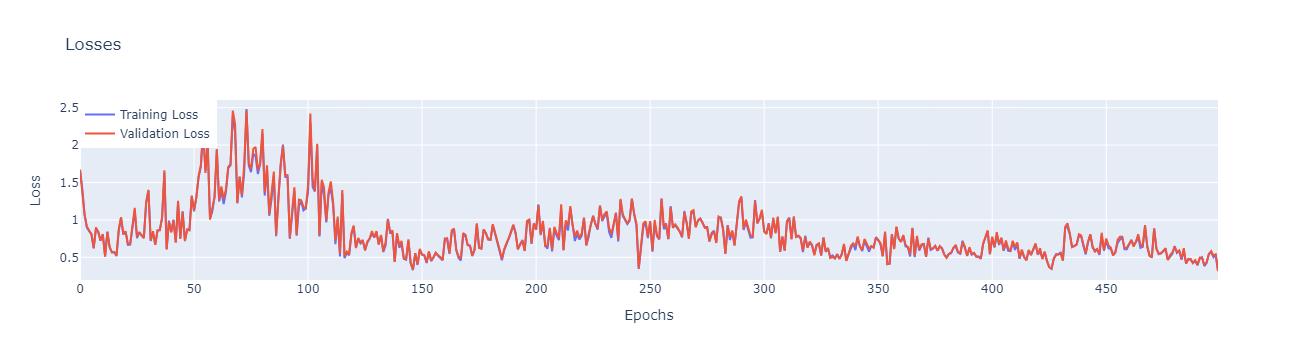

In [28]:
trainer.plot_losses()

The Weights at 50 Epoch


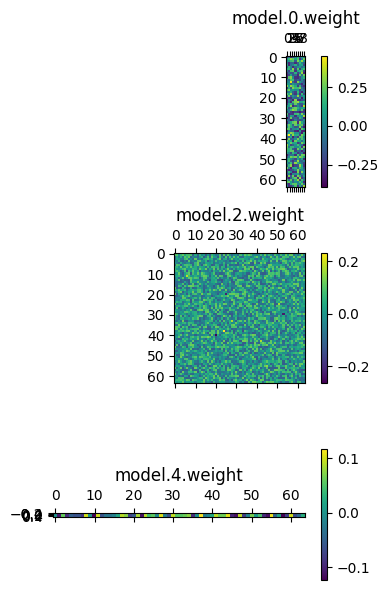

The Weights at 100 Epoch


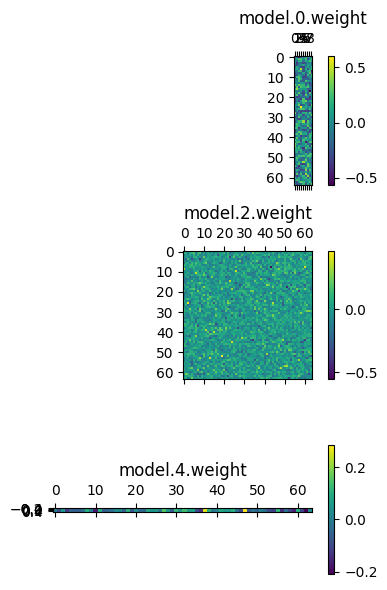

The Weights at 150 Epoch


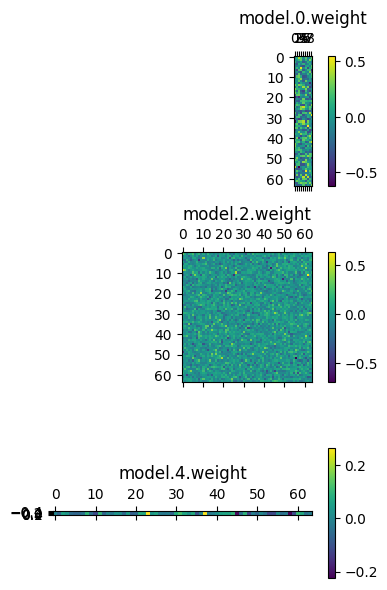

The Weights at 200 Epoch


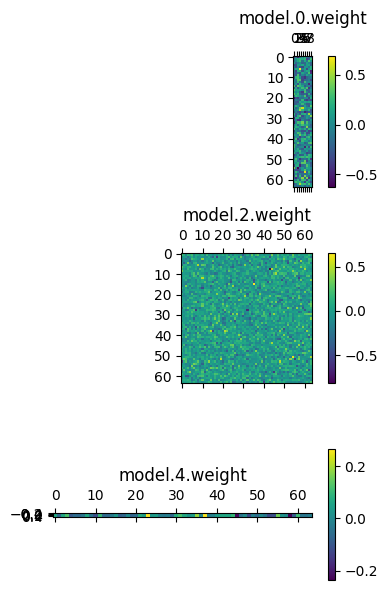

The Weights at 250 Epoch


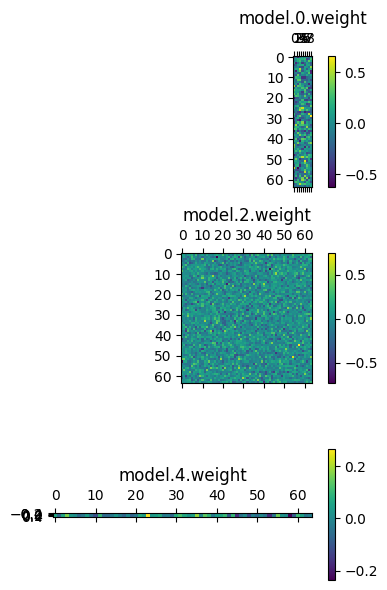

The Weights at 300 Epoch


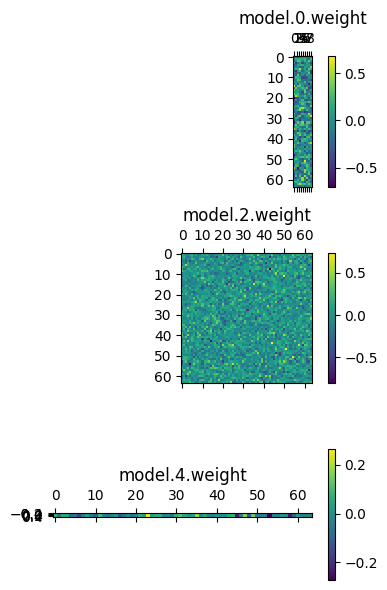

The Weights at 350 Epoch


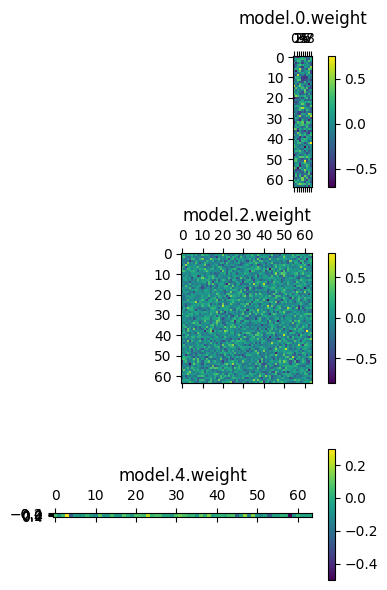

The Weights at 400 Epoch


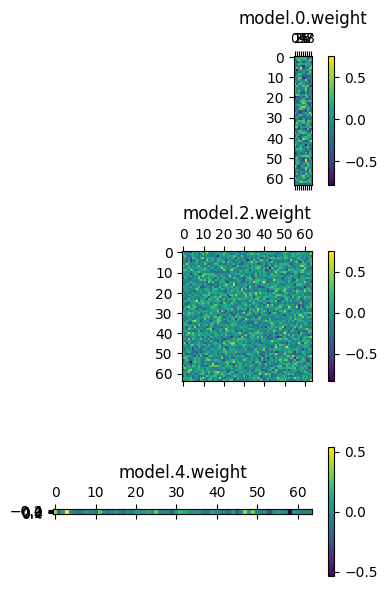

The Weights at 450 Epoch


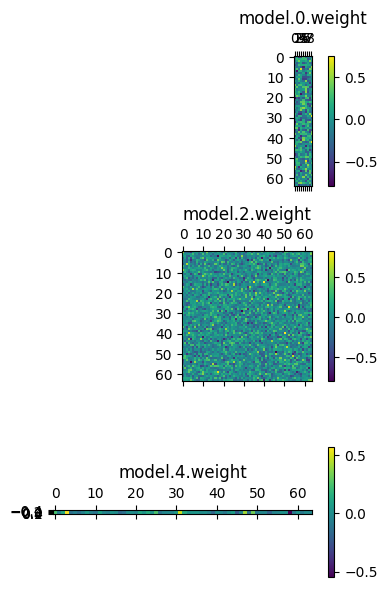

The Weights at 500 Epoch


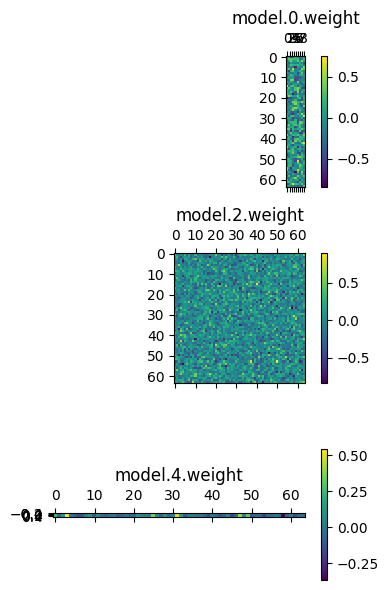

In [29]:
import matplotlib.pyplot as plt

def visualize_weights(named_parameters):
    weights = []
    layers = []
    
    for name in named_parameters:
        if 'weight' in name:
            weights.append(named_parameters[name].data.numpy())
            layers.append(name)

    fig, axs = plt.subplots(len(weights), 1, figsize=(4, len(weights) * 2))

    for ax, weight, layer_name in zip(axs, weights, layers):
        cax = ax.matshow(weight, cmap='viridis')
        ax.set_title(layer_name)
        plt.colorbar(cax, ax=ax)

    plt.tight_layout()
    plt.show()

a = best_model.named_parameters()
# print([(n, p.size()) for n, p in a])
# print([n, p.size()) for n, p in trainer.param_snapshots[0]])
# print(trainer.param_snapshots)
for i in range(len(trainer.param_snapshots)):
    print(f"The Weights at {(i+1)*50} Epoch")
    visualize_weights(trainer.param_snapshots[i])

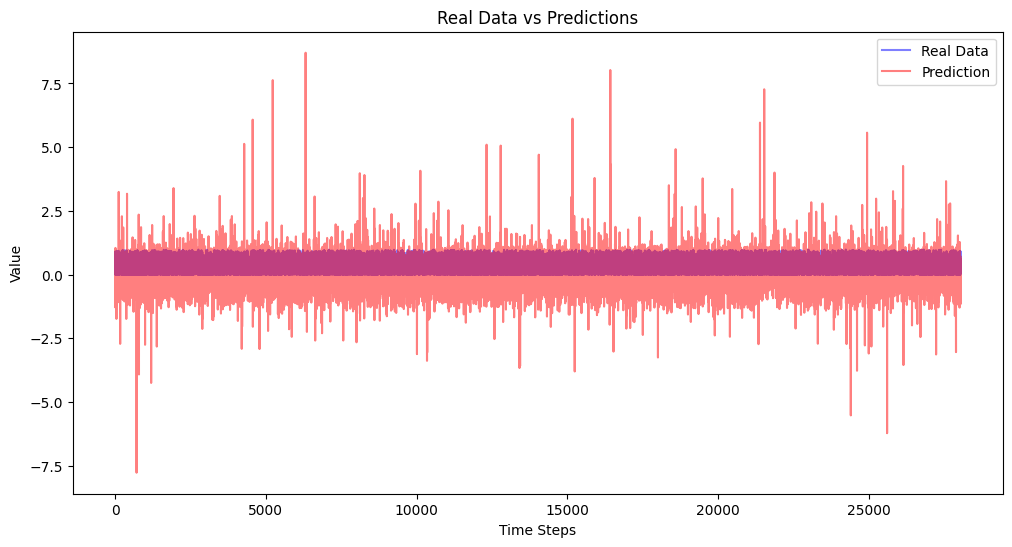

In [30]:
def plot_predictions(real_data, predictions):
    plt.figure(figsize=(12, 6))

    plt.plot(range(len(predictions)), real_data[:, 0], label='Real Data', color='blue', alpha=0.5)
    plt.plot(range(len(predictions)), predictions[:, 0], label='Prediction', color='red', alpha=0.5)

    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Real Data vs Predictions')
    plt.legend()
    plt.show()

plot_predictions(eval_dataset.labels.detach().numpy(), eval_predictions.detach().numpy())

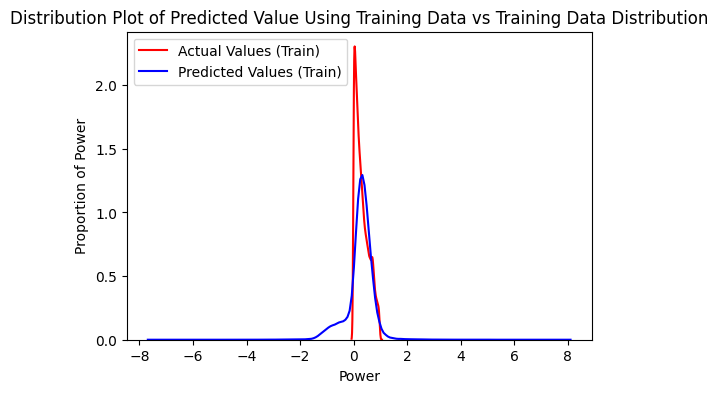

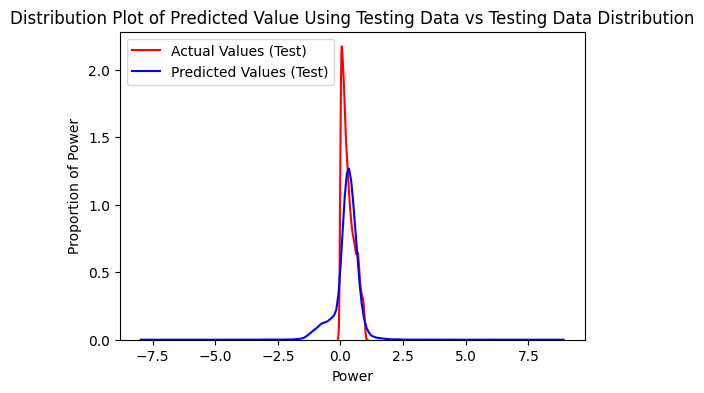

In [31]:
import seaborn as sns

def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
  width = 6
  height = 4
  plt.figure(figsize=(width, height))
  ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
  ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
  
  plt.title(Title)
  plt.xlabel("Power")
  plt.ylabel("Proportion of Power")

  plt.legend(loc='upper left')
  plt.show()
  plt.close()


DistributionPlot(train_dataset.labels.detach().numpy(), train_predictions.detach().numpy(), "Actual Values (Train)", "Predicted Values (Train)", 
                 "Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution")
DistributionPlot(eval_dataset.labels.detach().numpy(), eval_predictions.detach().numpy(), "Actual Values (Test)", "Predicted Values (Test)", 
                 "Distribution Plot of Predicted Value Using Testing Data vs Testing Data Distribution")